In [1]:
import torch
import numpy as np
import tensorly as tl
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
%load_ext autoreload
%autoreload 2
from tensor_regression import multinomial_tensor_regression as mtr

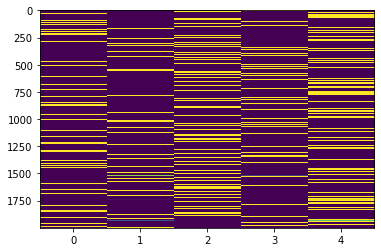

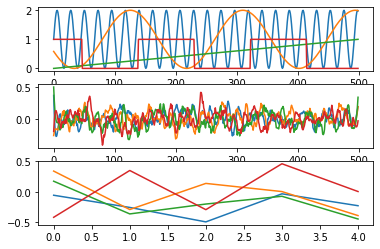

In [3]:
torch.manual_seed(321)
np.random.seed(321)

X_dims_fake = [2000, 500, 500]
nClasses_fake = 5

# y_true  = np.random.randint(0, nClasses_fake, X_dims_fake[0])
# y_true_oneHot = mtr.idx_to_oneHot(y_true, nClasses_fake)

Xcp_underlying_fake = [
                      torch.rand(X_dims_fake[0], 4)-0.5,
                      torch.vstack([torch.sin(torch.linspace(0, 140, X_dims_fake[1]))+1,
                                    torch.cos(torch.linspace(2,19,X_dims_fake[1]))+1,
                                    torch.linspace(0,1,X_dims_fake[1]),
                                    torch.cos(torch.linspace(0,17,X_dims_fake[1])) >0]).T ,
                      torch.tensor(scipy.signal.savgol_filter(np.random.rand(X_dims_fake[2], 4), 15, 3, axis=0))-0.5,
                    ]
Bcp_underlying_fake = Xcp_underlying_fake[1:] + [torch.rand(nClasses_fake, 4) -0.5]

tl.set_backend('pytorch')
X_fake = tl.cp_tensor.cp_to_tensor((np.ones(4), Xcp_underlying_fake))

y_trueProb_fake = mtr.model(X_fake, Bcp_underlying_fake, np.ones(4), [True, False, False])
y_trueIdx_fake = torch.argmax(y_trueProb_fake, dim=1)

plt.figure()
plt.imshow(y_trueProb_fake, aspect='auto', interpolation='none')

fig, axs = plt.subplots(len(Bcp_underlying_fake))
for ii in range(len(axs)):
    axs[ii].plot(Bcp_underlying_fake[ii]);

In [36]:
X = X_fake.numpy()
# X = (X - np.mean(X, axis=0))
y = y_trueIdx_fake.numpy()
DEVICE = mtr.set_device(use_GPU=True)

# h_vals = np.logspace(-50, 2, num=30, endpoint=True, base=10.0)
# h_vals = np.int64(np.linspace(1, 300, num=30, endpoint=True))
h_vals = np.arange(1)

loss_all = []
for ii, val in enumerate(h_vals):
    print(f'hyperparameter val: {val}')
    cpmlr = mtr.CP_logistic_regression(X, y, 
                                         rank=4,
                                         non_negative=[True, False, False],
                                         weights=None,
                                         Bcp_init=None,
                                         Bcp_init_scale=1,
                                         device=DEVICE,
                                         softplus_kwargs={
                                             'beta': 50,
                                             'threshold':1}
                                         )

    # tic = time.time()
    cpmlr.fit(lambda_L2=0.005, 
                max_iter=200, 
                tol=1e-50, 
                patience=10,
                verbose=1,
                running_loss_logging_interval=1,
                LBFGS_kwargs={
                    'lr' : 10, 
                    'max_iter' : 20, 
                    'max_eval' : None, 
                    'tolerance_grad' : 1e-07, 
                    'tolerance_change' : 1e-09, 
                    'history_size' : 100, 
                    'line_search_fn' : "strong_wolfe"
                }
             )
    # print(time.time() - tic)
    print(f'loss: {cpmlr.loss_running[-1]}')
    
    loss_all.append(cpmlr.loss_running[-1])

GPU is enabled.
hyperparameter val: 0
Convergence reached
loss: 0.9194563031196594


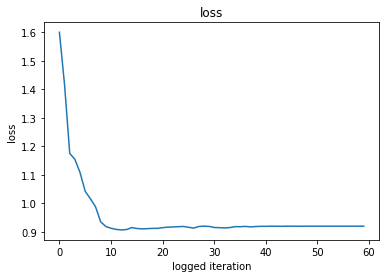

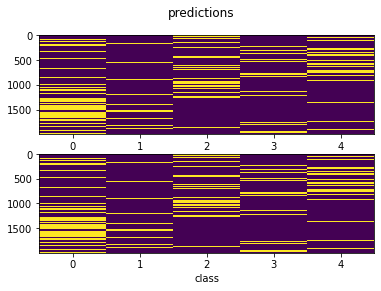

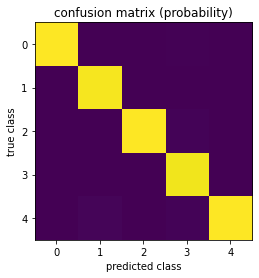

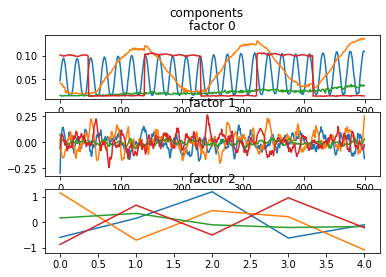

In [37]:
plt.figure()
plt.plot(cpmlr.loss_running);
plt.xlabel('logged iteration')
plt.ylabel('loss')
plt.title('loss')

prob, pred = cpmlr.predict()
fig, axs = plt.subplots(2)
axs[0].imshow(mtr.idx_to_oneHot(pred, cpmlr.n_classes), aspect='auto', interpolation='none')
axs[1].imshow(mtr.idx_to_oneHot(y_trueIdx_fake.numpy(), cpmlr.n_classes), aspect='auto', interpolation='none')
axs[1].set_xlabel('class')
fig.suptitle('predictions')

cm = cpmlr.make_confusion_matrix(prob_or_pred='pred')
fig = plt.figure()
plt.imshow(cm)
plt.ylabel('true class')
plt.xlabel('predicted class')
plt.title('confusion matrix (probability)')

Bcp_final = cpmlr.return_Bcp_final()
fig, axs = plt.subplots(len(Bcp_final))
for ii, val in enumerate(Bcp_final):
    axs[ii].set_title(f'factor {ii}')
    axs[ii].plot(val)
fig.suptitle('components');